# Konwolucyjne sieci neuronowe
Autor: Anna Dawid

Korekta: Artur Kalinowski

Dzisiaj poznamy prawdopodobnie najpopularniejszy model sieci neuronowej zaprojektowany do klasyfikacji obrazków wszelkiego rodzaju, a bardziej precyzyjnie: do wszelkich danych, w których istotna jest zależność przestrzenna. Zbudujemy przykładową sieć konwolucyjną (convolutional neural network, CNN), pobawicie się Dropoutem oraz ostatnim sposobem na zwiększanie generalizacji modelu, który poznamy na naszym kursie. Nazywa się on 'data augmentation', polega na generowaniu dodatkowych danych z naszego zestawu danych, bazując na prostych transformacjach - rotacjach, przerzucaniu, podkreślaniu krawędzi, itd. Będziemy znów pracować na zbiorze MNIST, czyli zbiorze czarno-białych obrazków z ręcznie napisanymi cyframi.

# Sieci neuronowe ze splotem (konwolucyjne)

Dzisiaj poznamy prawdopodobnie najpopularniejszy model sieci neuronowej zaprojektowany do klasyfikacji obrazków wszelkiego rodzaju, a bardziej precyzyjnie: do wszelkich danych, w których istotna jest zależność przestrzenna. Zbudujemy przykładową sieć ze splotem (convolutional neural network, CNN) 

Dodatkowo użyjemy techniki wzbogacania zbioru danych - `data augmentation`
Technika polega na generowaniu dodatkowych danych z istniejącego zestawu, bazując na prostych transformacjach - rotacjach, przerzucaniu, podkreślaniu krawędzi, itd. 

Dziś nadal będziemy pracować na zbiorze MNIST, czyli zbiorze czarno-białych obrazków z ręcznie napisanymi cyframi.

## Przygotowanie środowiska programistycznego

By zapewnić powtarzalność wyników ustawiany ziarno generatora liczb losowych:
```Python
seed = 128
rng = np.random.RandomState(seed)
```

In [1]:
import sys, os

from termcolor import colored
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import keras
from keras.datasets import mnist

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf

seed = 128
rng = np.random.default_rng(seed=seed)

def printScores(model, X, Y):
    Y_pred = np.argmax(model.predict(X), axis=1)
    # użyj classification_report() żeby policzyć najpopularniejsze miary 
    print("Classification report:")
    print(classification_report(Y,Y_pred))
    # wypisz macierz pomyłek 
    print("Confusion matrix:")
    print(confusion_matrix(Y, Y_pred))

def plotTrainingHistory(model):

    fig, axes= plt.subplots(1,2,figsize=(10,5))
    history = model.history
    axes[0].plot(history['accuracy'])
    axes[0].plot(history['val_accuracy'])
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['train', 'validation'], loc='upper left')

    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_ylabel('loss function')
    axes[1].set_xlabel('epoch')
    axes[1].legend(['train', 'validation'], loc='upper left')
    

def testModelOnMyDigits(model):    
    #Code created by M.Fila
    if not os.path.isdir("colab_freehands"):
        !git clone https://github.com/m-fila/colab_freehands.git

    from colab_freehands.canvas import Canvas  
    canvas = Canvas(line_width=2)
    example = (
        canvas.to_array(size=(20, 20), margin=(4, 4), dtype=np.float32, weighted=True) / 255
    )
    predictions = model(np.expand_dims(example, (0, -1)))
    plt.imshow(example, cmap="gray")
    plt.show()
    print(
        "Predicted class: {} ({:.0f}%)".format(
            np.argmax(predictions), np.max(predictions) * 100
        )
    )

2023-12-18 10:08:07.345327: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Import danych MNIST

Proszę:

* wczytać dane MNIST
* wypisać na ekran kształt danych uczących i testowych.

11490434/11490434 [==============================] - 1s 0us/step
Training data features: (60000, 28, 28)
Training data labels: (60000,)
Test data features: (10000, 28, 28)
Test data labels: (10000,)
Trainig data example number 0: label: 5


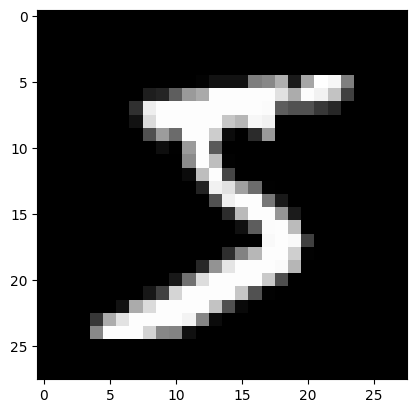

In [2]:
#BEGIN_SOLUTION
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(colored("Training data features:", "blue"), X_train.shape)
print(colored("Training data labels:", "blue"),Y_train.shape)

print(colored("Test data features:", "blue"),X_test.shape)
print(colored("Test data labels:", "blue"),Y_test.shape)

print(colored("Trainig data example number 0:", "blue"), "label:",Y_train[0])
plt.imshow(X_train[0], cmap='gray');
#END_SOLUTION
pass

## Wstępne przygotowanie danych (ang. preprocessing)


Sieci ze splotem przyjmują na wejściu kolorowe obrazy. Kształt pojedynczego przykładu to: `(x pixels, y pixels, channels)`, gdzie:
- x, y pixels - liczba pikseli w obu kierunkach
- channels - liczba kolorów, czyli "kanałów"

Dane które analizujemy mają postać dwuwymiarowych macierzy o kształcie `(x pixels, y pixels)`. Proszę:


* zmienić kształt danych wejściowych na `(x pixels, y pixels, channels)`. W naszym przypadku mamy jeden kolor, czyli kanał. 
* wypisać kształt macierzy po spłaszczeniu. Czy wymiar jest zgodny z oczekiwaniem?
* znormalizować wartości danych do zakresu **[0,1]** korzystając z funkcji ```numpy.amax(...)```

Oczekiwany rezultat to:

```
Training data shape before reshaping: (60000, 28, 28)
Training data shape after flattening: (60000, 28, 28, 1)
```

**Wskazówka**: Nowy kształt macierzy można uzyskać dodając 1 do starego:
```
X_train.shape+(-1,)
```

In [3]:
#BEGIN_SOLUTION
print("Training data shape before reshaping:",X_train.shape)

X_train = X_train.reshape(X_train.shape+(-1,))
X_test = X_test.reshape(X_test.shape+(-1,))

print("Training data shape after reshaping:",X_train.shape)

maxValue = float(np.amax(X_train))
print("Maximum value in training data:",maxValue)

X_train = X_train.astype('float32')/maxValue
X_test = X_test.astype('float32')/maxValue
#END_SOLUTION
pass

Training data shape before reshaping: (60000, 28, 28)
Training data shape after reshaping: (60000, 28, 28, 1)
Maximum value in training data: 255.0


## Zmiana reprezentacji etykiet


* zamienić etykiety na reprezentację "one hot encoding"
* wypisać na ekran oryginalne i nowe kodowanie etykiety dla przykładu 0 ze zbioru uczącego

In [4]:
#BEGIN_SOLUTION
print("Original label encoding:",Y_train[0], "shape:", Y_train.shape)
depth = 10

Y_train = tf.one_hot(Y_train, depth)
Y_test = tf.one_hot(Y_test, depth)

print("One hot label encoding for training data:",Y_train[0], "shape:", Y_train.shape)
print("One hot label encoding for test data:",Y_test[0], "shape:", Y_test.shape)
#END_SOLUTION
pass

Original label encoding: 5 shape: (60000,)
One hot label encoding for training data: tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32) shape: (60000, 10)
One hot label encoding for test data: tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32) shape: (10000, 10)


2023-12-18 10:08:10.313518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 10:08:10.316425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 10:08:10.316537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Stworzenie  architektury sieci konwolucyjnej

W dzisiejszym modelu będziemy używali nowych rodzajów warstw:

* warstwy konwolucyjnej - klasy typu `tf.keras.layers.Conv2D` itd.

Warstwa konwolucyjna dokonuje splotu na danych wejściowych (zielony rysunek) z filtrem (czerwone wartości w żółtym kwadracie).  Jako wynik zwraca nowe dane (różowy rysunek). Żółta macierz przesuwająca się po zielonym obrazku (z czerwonymi elementami, które się nie zmieniają) to filtr lub jądro. 
Przesuwa się on po danych wejściowych w sposób ustalony przez hiperparametry takie jak
- size - rozmiar samego filtra, tutaj: (3,3)
- stride - krok, tutaj gifie = (1,1)
- padding - co zrobić kiedy filtr wykracza poza dane, czyli gdyby w tym przykładzie filtr był 4x4: można ograniczyć ruch tylko do ruchów bez wychodzenia poza ramkę (padding = valid, domyślny), można zrobić ramkę powielającą piksele sąsiadujące (padding = same), można zrobić ramkę z zer, itd.


Wielkości modyfikowane w ramach treningu to wartości wag filtra pozostałe wielkości to hiperparametry.
W sytuacji kiedy kanałów jest więcej niż jeden wartości dla wszystkich kanałów są domyślnie sumowane dla danego piksela. Zwykle każda warstwa splotu zawiera wiele filtrów, czyli wiele wariantów wartości wag.


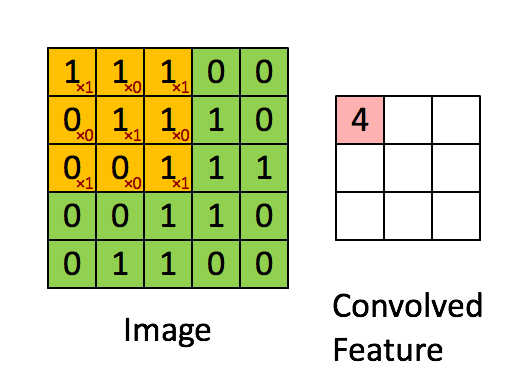

* warstw  łączących  - klasy typu `tf.keras.layers.MaxPooling2D`, `AveragePooling2D` itd.

Warstwa łącząca dokonuje redukcji rozmiaru danych wejściowych (zielony rysunek) z filtrem (fioletowy kwadrat).  Jako wynik zwraca nowe dane (żółty rysunek). Rozmiar filtra i parametry jego ruchu: `size`, `stride` i `padding` są hiperparametrami modelu. Dane pokryte przez filtr są redukowane do
jednej wartości. Najczęściej spotykane algorytmy redukcji to:

* ``maxpool`` - wybierany jest element o maksymalnej wartości
* ``average pool`` - obliczana jest średnia elementów

W sytuacji kiedy kanałów jest więcej niż jeden operacja "pooling" jest wykonywana dla każdego kanału oddzielnie.



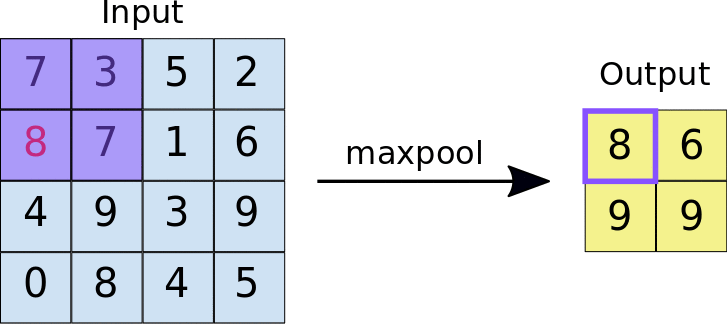

### Definicja architektury sieci ze splotem (CNN)

Proszę zdefiniować sieć neuronową o architekturze w pełni połączonej (ang. fully connected). Sieć powinna mieć:
* warstwę wejściową
* warstwy ukryte złozone z par:
    * warstwa `Conv2D` o parametrach: `filters=nFilters, kernel_size=kernel_size, activation=tf.nn.relu`
    * warstwa `MaxPool` o parametrach `pool_size=pool_size`

* warstwę spłaszczającą 
* warstwę gęstą o parametrach `nNeurons, activation=tf.nn.relu`
* wartę wyjściową z funkcją aktywacji ```sofmax```  

Proszę:

* dokończyć funkcję ```getModel(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, inputShape, outputWidth)``` która tworzy model o zdefiniowanej powyżej architekturze
* w funkcji skompilowac model tak by:
    * jako algorytmu minimalizacji używał `adam`
    * jako funkcji straty używał `categorical_crossentropy`
    * jako metryki używał `accuracy`
* obliczyć samodzielnie liczbę parametrów pierwszej warstwy "MaxPool" i porównać ją z wynikiem działania funkcji ```model.summary(...)```
* porównać liczbę parametrów w obecnym modelu i modelu z poprzednich zajęć
* obejrzeć rysunek przedstawiający architekturę modelu, uzyskany przy pomocy funkcji ```tf.keras.utils.plot_model(...)```

In [5]:
#BEGIN_SOLUTION
def getModel(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, inputShape, outputWidth):
      
    inputs = tf.keras.Input(shape=inputShape)
    x = inputs
    for iHidden in range(nHiddenLayers):   
        x = tf.keras.layers.Conv2D(filters=nFilters, kernel_size=kernel_size, activation=tf.nn.relu)(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(x)
  
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(nNeurons, activation=tf.nn.relu)(x)
    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

nFilters = 32
kernel_size = 3
pool_size = (2,2)
nNeurons = 128 
nHiddenLayers = 1 
inputShape = (28, 28, 1)
outputWidth = 10

model_basic = getModel(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, inputShape, outputWidth)

print(colored("Number of parameters for the first maxPool layer:","blue"),(kernel_size**2+1)*nFilters)   

model_basic.summary()
tf.keras.utils.plot_model(model_basic, 'ML_model.png', show_shapes=True)
#END_SOLUTION
pass

Number of parameters for the first maxPool layer: 320
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
       

## Trening modelu

Proszę:

* przeprowadzić trening dla `10` epok z rozmiarem paczki wynoszącym `128`
* narysować ewolucję funkcji straty w kolejnych epokach
* porównać wartości metryki na danych uczących i walidacyjnych. Jaki wniosek wynika z tego porównania?
* porównać metryki obecnego modelu z modelem z siecią gęstą. Jaki się sprawuje obecny model? 

**Uwaga**: proszę połączyć środowisko wykonawcze by używało karty graficznej "GPU": z menu na górze:
```
Środowisko wykonawcze -> Zmień typ środowiska wykonawczego
```
Oczekiwany efekt:
```
Epoch 1/15
329/329 [==============================] - 4s 5ms/step - loss: 0.2923 - accuracy: 0.9166 - val_loss: 0.1296 - val_accuracy: 0.9632

Epoch 15/15
329/329 [==============================] - 1s 4ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0650 - val_accuracy: 0.9852
```

**Wskazówka**: w czasie treningu proszę użyć parametru ```validation_split=0.3``` by uzyskać automatyczny podział danych uczących na uczące i walidacyjne.

Epoch 1/15


2023-12-18 10:08:12.581514: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-12-18 10:08:21.729132: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4e2c01b0e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-18 10:08:21.729231: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-12-18 10:08:21.742775: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-18 10:08:21.850422: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 [==============================] - 15s 4ms/step - loss: 0.2723 - accuracy: 0.9224 - val_loss: 0.1174 - val_accuracy: 0.9657
Epoch 2/15
329/329 [==============================] - 1s 3ms/step - loss: 0.0829 - accuracy: 0.9753 - val_loss: 0.0786 - val_accuracy: 0.9771
Epoch 3/15
329/329 [==============================] - 1s 3ms/step - loss: 0.0536 - accuracy: 0.9839 - val_loss: 0.0703 - val_accuracy: 0.9776
Epoch 4/15
329/329 [==============================] - 1s 3ms/step - loss: 0.0411 - accuracy: 0.9881 - val_loss: 0.0714 - val_accuracy: 0.9774
Epoch 5/15
329/329 [==============================] - 1s 4ms/step - loss: 0.0301 - accuracy: 0.9911 - val_loss: 0.0631 - val_accuracy: 0.9816
Epoch 6/15
329/329 [==============================] - 1s 3ms/step - loss: 0.0223 - accuracy: 0.9935 - val_loss: 0.0630 - val_accuracy: 0.9818
Epoch 7/15
329/329 [==============================] - 1s 3ms/step - loss: 0.0151 - accuracy: 0.9960 - val_loss: 0.0635 - val_accuracy: 0.9821
Epoch 8/15
329/3

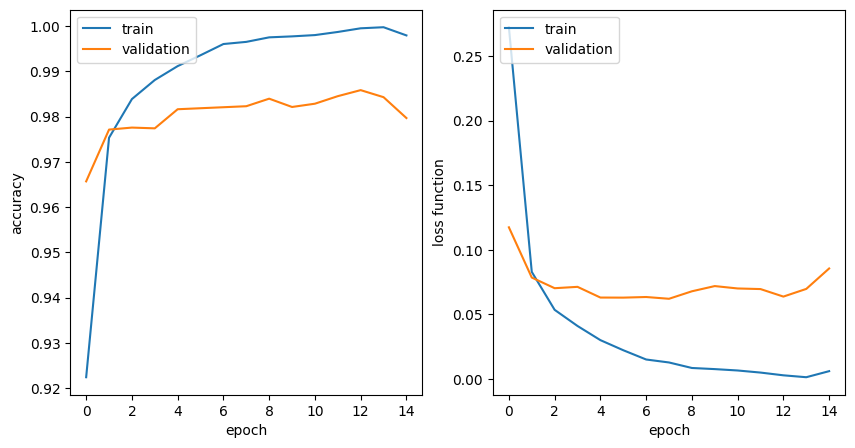

In [6]:
%%time 
#BEGIN_SOLUTION
epochs = 15
batch_size = 128

model_basic_fit = model_basic.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3)
plotTrainingHistory(model_basic_fit)
printScores(model_basic, X_test, np.argmax(Y_test, axis=1)) 
#END_SOLUTION
pass

## Ilustracja błędnie sklasyfikowanych przykładów.

1/1 [==============================] - 0s 11ms/step


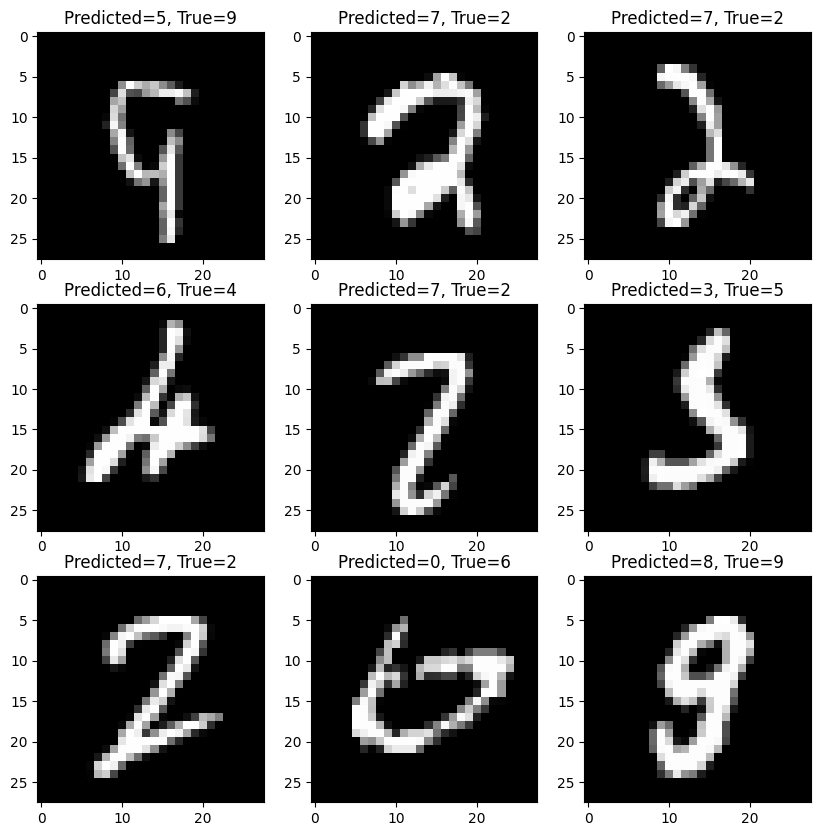

In [7]:
Y_pred = model_basic.predict(X_test).argmax(axis=1)
missclassified_indices  = Y_pred != np.argmax(Y_test, axis=1)
missclassified_data = X_test[missclassified_indices,:,:,:]
missclassified_labels = tf.boolean_mask(Y_test,missclassified_indices)

def plotExamples(model, data, labels):
    fig, axes= plt.subplots(3,3,figsize=(10,10))
    for k, ax in zip(range(axes.size), axes.reshape(-1)):
        ax.imshow(data[k,:,:,0].reshape(28,28), cmap='gray', interpolation='none')
        Y_pred = model.predict(data[k:k+1,:,:,:])
        Y_pred = np.argmax(Y_pred, axis=1)[0]   
        Y_true = np.argmax(labels[k])              
        ax.set_title("Predicted={}, True={}".format(Y_pred, Y_true))
   

plotExamples(model_basic, missclassified_data, missclassified_labels)

## Model z warstwą "dropout" oraz regularyzacją L2

Proszę:

* napisać funkcję ```getModelWithDropout(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, inputShape, outputWidth)```
która zawiera warstwę `tf.keras.layers.Dropout()` po warstwie `MaxPool2D`. Dodatkowo parametry modelu powinny mieć regularyzację L2.
* stworzyć nowy model `model_with_reg = getModelWithRegularisation(...)`
* wytrenować model
* wypisać jego metryki i sprawdzić działanie na **tych** samych przykładach, które były błędnie sklasyfikowane przez poprzedni model.

Jak wyglądają krzywe metryk dla zbiorów uczącego i walidacyjnego w funkcji numeru epoki? 

Czy z ich zachowania można wyciągnąć jakiś wniosek odnośnie czasu treningu?

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               692352    
                                                           

2023-12-18 10:08:42.731950: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 [==============================] - 0s 851us/step
Classification report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.98      0.97      1032
           3       1.00      0.94      0.97      1010
           4       0.99      0.97      0.98       982
           5       0.96      0.99      0.97       892
           6       0.98      0.98      0.98       958
           7       0.99      0.96      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Confusion matrix:
[[ 977    0    1    0    0    0    0    1    1    0]
 [   0 1129    4    0    0    0    1    0    1    0]
 [   7    0 1013    0    1    0    1 

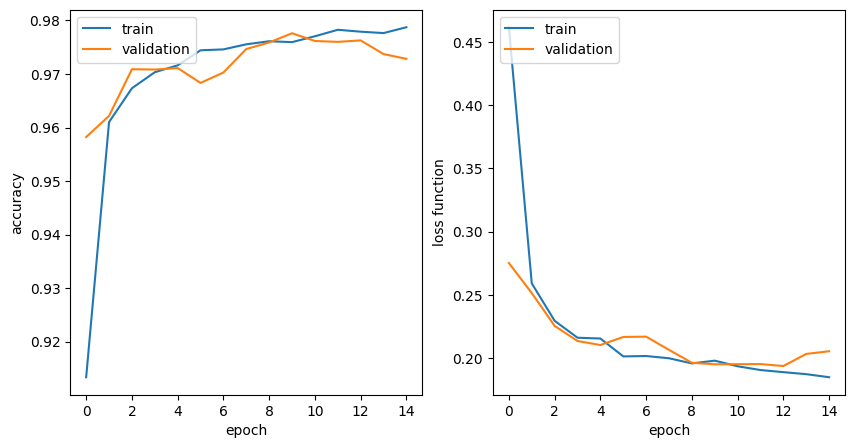

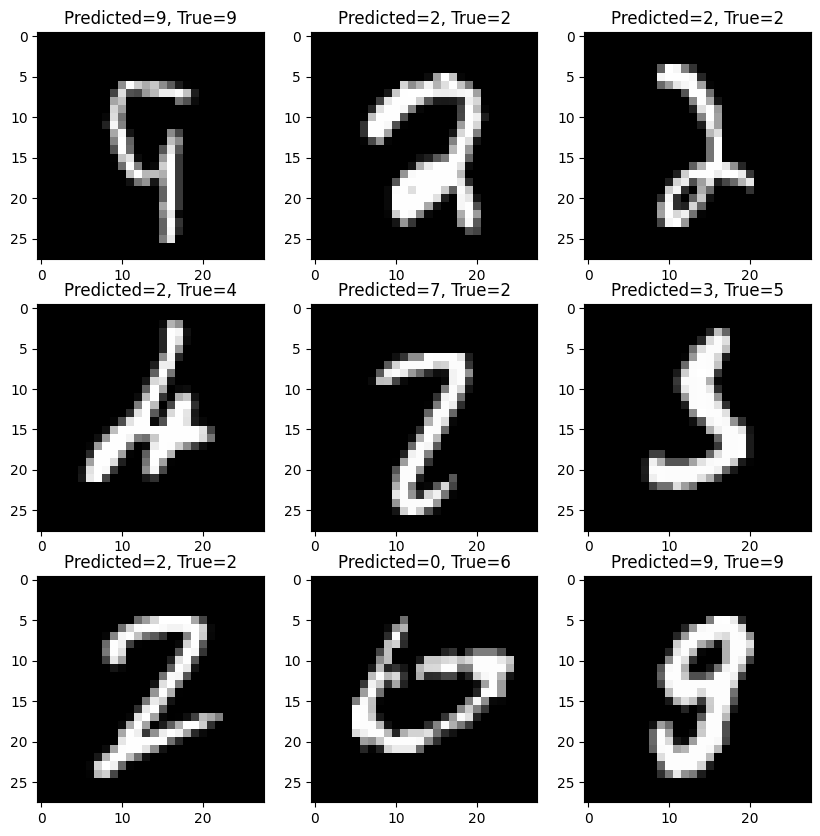

In [8]:
%%time 
#BEGIN_SOLUTION
def getModelWithRegularisation(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, l2_lambda, inputShape, outputWidth):
      
    inputs = tf.keras.Input(shape=inputShape)
    x = inputs
    for iHidden in range(nHiddenLayers):   
        x = tf.keras.layers.Conv2D(filters=nFilters, 
                                   kernel_size=kernel_size, 
                                   kernel_regularizer =  tf.keras.regularizers.l2(l2_lambda),
                                   activation=tf.nn.relu)(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
  
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(nNeurons, 
                              kernel_regularizer =  tf.keras.regularizers.l2(l2_lambda),
                              activation=tf.nn.relu)(x)
    outputs = tf.keras.layers.Dense(outputWidth, 
                                    kernel_regularizer =  tf.keras.regularizers.l2(l2_lambda),
                                    activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

dropout_rate = 0.2
l2_lambda = 0.001

model_with_reg = getModelWithRegularisation(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, l2_lambda, inputShape, outputWidth)
model_with_reg.summary()
model_with_reg_fit = model_with_reg.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, verbose=0)
plotTrainingHistory(model_with_reg_fit)  
printScores(model_with_reg, X_test, np.argmax(Y_test, axis=1)) 
plotExamples(model_with_reg, missclassified_data, missclassified_labels)
#END_SOLUTION
pass

Krzywa dokładności dla danych walidacyjnych nie odbiega od krzywej dla danych treningowych po 15 epokach. To wskazuje, że trening można przedłużyć.
Proszę wytrenować model przez kolejne 20 epok i przeprowadzić na nim sprawdziany jak poprzednio.

313/313 [==============================] - 0s 888us/step
Classification report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.96      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confusion matrix:
[[ 976    1    1    0    0    0    1    1    0    0]
 [   0 1129    2    3    0    0    1    0    0    0]
 [   4    4 1009    1    2    0    0 

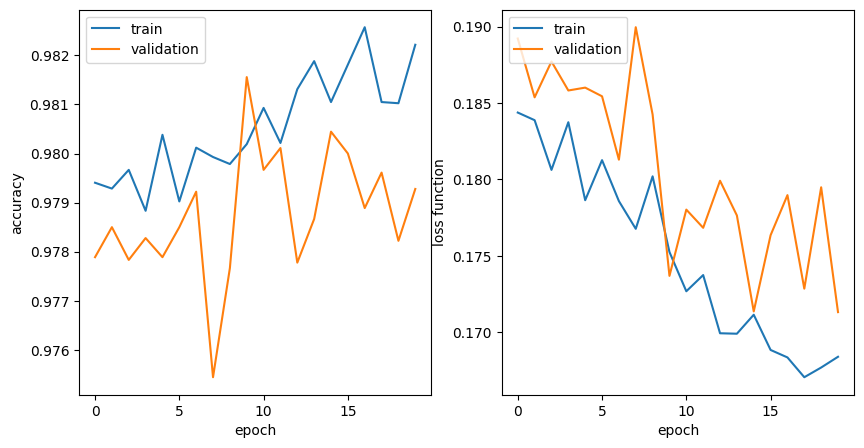

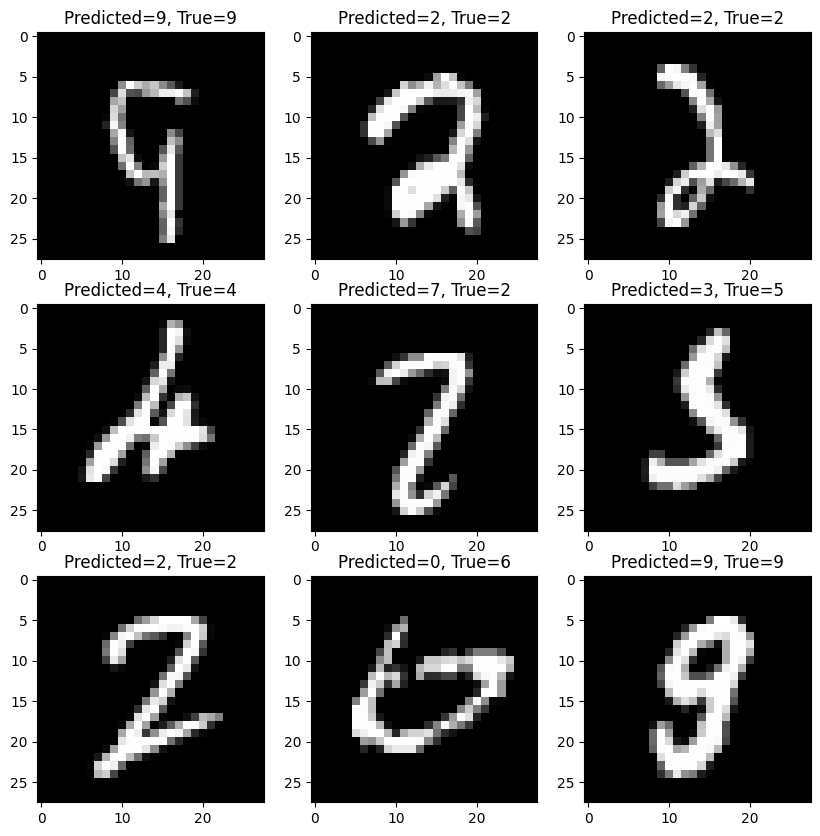

In [9]:
%%time
#BEGIN_SOLUTION
epochs = 20
model_with_reg_fit = model_with_reg.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, verbose=0)
plotTrainingHistory(model_with_reg_fit)  
printScores(model_with_reg, X_test, np.argmax(Y_test, axis=1)) 
plotExamples(model_with_reg, missclassified_data, missclassified_labels)
#END_SOLUTION
pass

## Generacja dodatkowych danych (ang. data augmentation)

Data augmentation polega na generowaniu dodatkowych danych z naszego zestawu danych, bazując na prostych transformacjach - rotacjach, przerzucaniu, podkreślaniu krawędzi, itd. To muszą być transformacje, o których wiemy, że nie powinny wpływać na informacje zawarte w naszych danych. 
Możemy w ten sposób np. nauczyć maszynę, że tożsamość obiektów na rysunkach nie zależy od ich orientacji. 

Dodatkowe dane mogą być uzyskane na różne sposoby. Jednym z nich jest dodanie do modelu warstwy która będzie losowo modyfikowała podany przykład.
Tak warstwa jest aktywna **tylko** w czasie treningu. Lista dostępny modyfikacji w pakiecie TensorFlow jest 
[tutaj](https://www.tensorflow.org/guide/keras/preprocessing_layers).

[Tutaj](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) 
znajdują się przykłady zastosowania różnych transformacji.


Proszę:
* narysować pierwszy przykład ze zbioru uczącego po losowym obrocie w zakresie $\pm$0.05 korzystając z warstwy `tf.keras.layers.RandomRotation()`

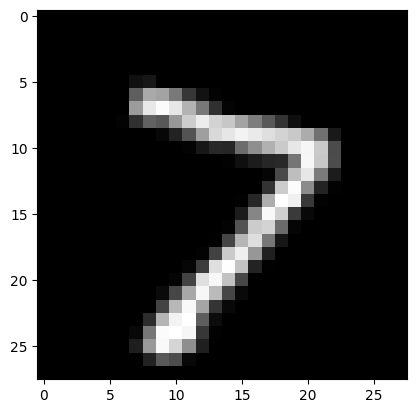

In [10]:
#BEGIN_SOLUTION
image = tf.keras.layers.RandomRotation((-0.05, 0.05))(X_test[0,:,:,:])
plt.imshow(image, cmap=plt.get_cmap('gray'));
#END_SOLUTION
pass

## Trening z użyciem "data augmentation"

Proszę:

* napisać funkcję, `getModelWithAugmentation(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, l2_lambda, inputShape, outputWidth)`
  która tworzy model z warstwą "data augmentation", oraz pozostałymi warstwami takimi jak tworzone przez funkcję `getModelWithRegularisation(...)`
* stworzyć nowy model `model_with_aug = getModelWithAugmentation(...)`
* wytrenować model
* wypisać jego metryki i sprawdzić działanie na **tych** samych przykładach, które były błędnie sklasyfikowane przez poprzedni model.

A następnie wytrenować model, wypisać jego metryki i sprawdzić działanie na **tych** samych przykładach, które były błędnie sklasyfikowane przez model `model_basic`. 

**Czy zastosowana metoda wzbogacania danych poprawia wydajność modelu?**

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 random_rotation_1 (RandomR  (None, 28, 28, 1)         0         
 otation)                                                        
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0   

2023-12-18 10:09:27.781385: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 [==============================] - 0s 836us/step
Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.99      0.97      0.98      1010
           4       0.97      1.00      0.98       982
           5       0.98      0.99      0.99       892
           6       1.00      0.96      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.97      0.96      0.96       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confusion matrix:
[[ 976    1    1    0    0    0    0    1    1    0]
 [   0 1129    2    0    1    0    1    1    1    0]
 [   3    1 1003    4    2    0    0 

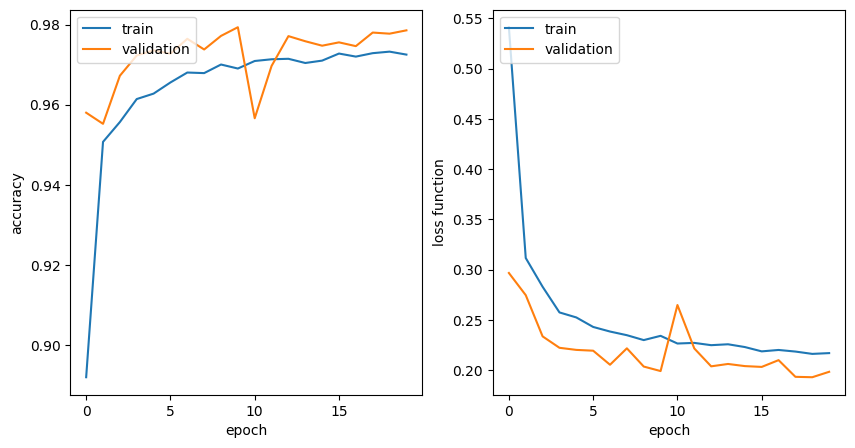

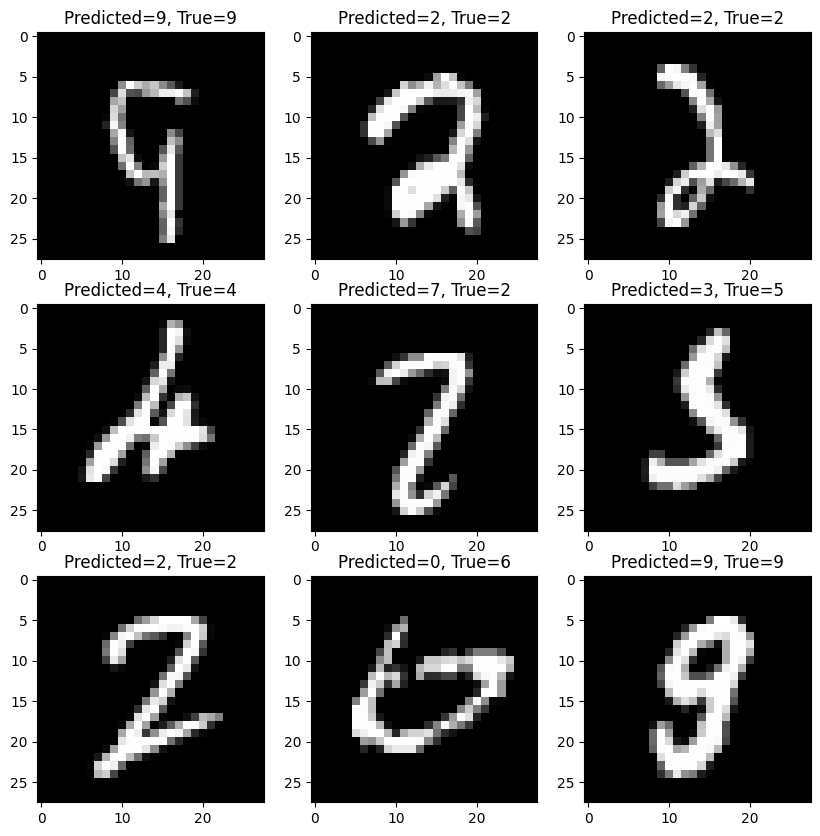

In [11]:
%%time 
#BEGIN_SOLUTION
def getModelWithAugmentation(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, l2_lambda, inputShape, outputWidth):
      
    inputs = tf.keras.Input(shape=inputShape)
    x = tf.keras.layers.RandomRotation((-0.05, 0.05))(inputs)
    for iHidden in range(nHiddenLayers):   
        x = tf.keras.layers.Conv2D(filters=nFilters, 
                                   kernel_size=kernel_size, 
                                   kernel_regularizer =  tf.keras.regularizers.l2(l2_lambda),
                                   activation=tf.nn.relu)(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
  
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(nNeurons, 
                              kernel_regularizer =  tf.keras.regularizers.l2(l2_lambda),
                              activation=tf.nn.relu)(x)
    outputs = tf.keras.layers.Dense(outputWidth, 
                                    kernel_regularizer =  tf.keras.regularizers.l2(l2_lambda),
                                    activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_with_aug = getModelWithAugmentation(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, l2_lambda, inputShape, outputWidth)
model_with_aug.summary()
model_with_aug_fit = model_with_aug.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, verbose=0)
plotTrainingHistory(model_with_aug_fit)  
printScores(model_with_aug, X_test, np.argmax(Y_test, axis=1)) 
plotExamples(model_with_aug, missclassified_data, missclassified_labels)
#END_SOLUTION
pass

Techniki przedstawione powyżej dają różne efekty w zależności od zagadnienia. Nie zawsze są one konieczne.

Proszę:

* wskazać model, który będzie miał najmniejszą liczbę błednie zidentyfikowanych cyfr w zbiorze testowym.

In [12]:
#BEGIN_SOLUTION
def misIdCount(model, X, Y):
    Y_pred = model.predict(X).argmax(axis=1)
    missclassified_indices  = Y_pred != np.argmax(Y, axis=1)
    return np.count_nonzero(missclassified_indices)
    
print("Misidentified examples count:")
print(colored("Basic:\t\t","blue"),misIdCount(model_basic, X_test, Y_test))
print(colored("Regularised:\t","blue"),misIdCount(model_with_reg, X_test, Y_test))
print(colored("Augmented:\t","blue"),misIdCount(model_with_aug, X_test, Y_test))
#END_SOLUTION
pass

Misidentified examples count:
313/313 [==============================] - 0s 815us/step
Basic:		 174
313/313 [==============================] - 0s 859us/step
Regularised:	 175
313/313 [==============================] - 0s 829us/step
Augmented:	 203


Proszę:

* wytrenować model, który będzie miał mniej niż 100 błędnie zidentyfikowanych przykładów w zbiorze testowym

2023-12-18 10:09:59.650628: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 [==============================] - 0s 892us/step
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Confusion matrix:
[[ 978    0    1    0    0    0    0    1    0    0]
 [   0 1132    0    1    0    0    0    2    0    0]
 [   2    1 1025    0    1    0    0 

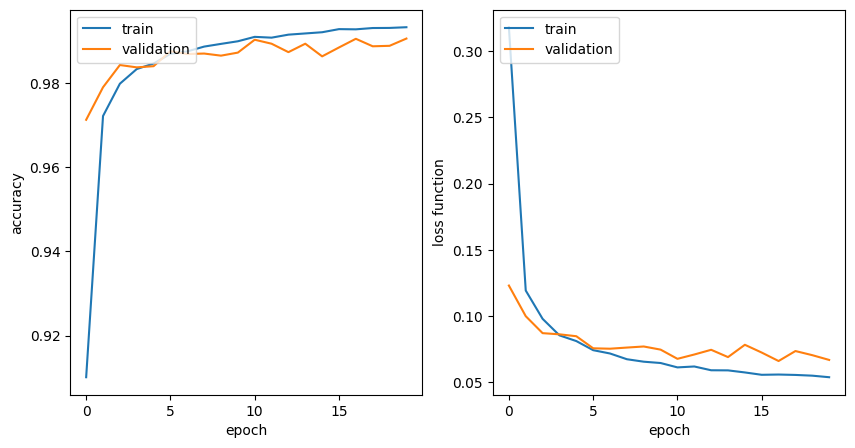

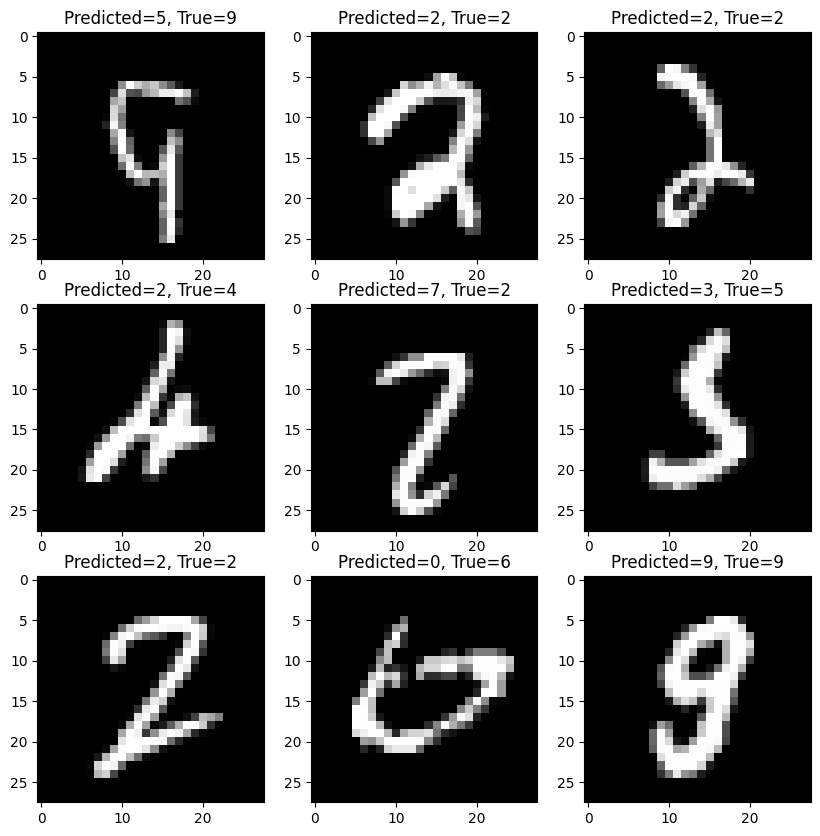

In [13]:
%%time 
#BEGIN_SOLUTION
nFilters = 32
kernel_size = 3
pool_size = (2,2)
nNeurons = 128 
nHiddenLayers = 2 
inputShape = (28, 28, 1)
outputWidth = 10

dropout_rate = 0.2
l2_lambda = 1E-4

epochs = 20
batch_size = 64

model_final = getModelWithRegularisation(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, l2_lambda, inputShape, outputWidth)
#model_final = getModel(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, inputShape, outputWidth)

model_final_fit = model_final.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, verbose=0)
plotTrainingHistory(model_final_fit)  
printScores(model_final, X_test, np.argmax(Y_test, axis=1)) 
plotExamples(model_final, missclassified_data, missclassified_labels)
print("Misidentified examples count:")
print(colored("Final:\t","blue"),misIdCount(model_final, X_test, Y_test))
#END_SOLUTION
pass